In [1]:
import numpy as np
import gensim
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from collections import defaultdict
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from neurotools.language.simple_tokenizer import SimpleTokenizer
%matplotlib inline

# Volkswagen Social Media Success #1

## Plan
1. Use the average of word vectors (sentence vector) as the representation of an FB post.
2. Get similarity of sentence vector with Neuro Flash dimensions.
3. Get correlations between dimensions, word ranks and success metric.

## Notebook Contents
1. Load the tokenizer, embedding and data files
2. Tokenize, Define Metric
3. Analyze word frequencies
4. Correlations with dimensions
5. Conclusion

# Load the tokenizer, embedding and data files

In [2]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


In [3]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [4]:
# get word ranks from embedding model
word_rank = pd.Series(list(emb.vocab.keys())).reset_index()

In [5]:
# divide word ranks into deciles
rank_labels = ['0-25', '25-50', '50-75', '75-100']
word_rank['percentile'] = pd.qcut(word_rank['index'], 4, labels = rank_labels)

In [6]:
rank_dict = dict(zip(word_rank[0].values, word_rank['percentile'].values))

In [7]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [8]:
dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'pl']]

# drop dimensions with no words
dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
dimensions['pl'] = dimensions['pl'].map(tokenizer.tokenize)
# calculate average vector of words in the dimension
dimensions['dimension'] = dimensions['pl'].map(lambda x: get_average_vector(x, emb))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [9]:
# read volkswagen FB data
volkswagen = pd.read_csv('data/volkswagenpolska.csv - volkswagenpolska.csv.csv', encoding='utf-8')

# Tokenize, Define Metric

In [10]:
relevant = volkswagen[['Post_utime', 'Post_text', 'Post_type', 'Total_likes', 'Total_comments', 'Shares_count']].groupby('Post_text').head(1).reset_index().drop(columns = 'index')

In [11]:
relevant = relevant[~relevant['Post_text'].isnull()]

In [12]:
relevant['Post_text'] = relevant['Post_text'].map(tokenizer.tokenize)

In [13]:
# build Dictionary of words in Post_text
dictionary = Dictionary(relevant['Post_text'].values)

In [14]:
relevant['bow'] = relevant['Post_text'].map(lambda x: dict(dictionary.doc2bow(x)))

Define success as (1/8) Likes + Shares + Comments. In essence, we weigh shares and comments higher since these are more indicative of interaction.

https://blog.marketo.com/2013/04/contagious-content-facebook-posts-that-get-shared-like-crazy.html

In [15]:
relevant['success'] = (1/8) * relevant['Total_likes'] + relevant['Total_comments'] + relevant['Shares_count']

In [16]:
# remove rows with no words
relevant = relevant[relevant['bow'].map(lambda x: len(x.items())) != 0]

In [17]:
def fill_word_frequency(row):
    # define new rows containg word frequency, one row for each word in the dictionary
    bow = row['bow']
    for index in bow.keys():
        row[dictionary[index]] = bow[index]
    return row
relevant = relevant.apply(fill_word_frequency, axis=1)

In [18]:
# save text and success values in a csv file
relevant[['Post_text', 'success']].to_csv('./data/simplified_data.csv', index=False)

# Analyze word frequencies
We look at raw word frequencies and the words that appear when success is high.

In [19]:
num_appearance = (~pd.isnull(relevant).drop(columns = ['bow', 'Post_utime', 'Post_text', 'Post_type', 'Total_likes', 'Total_comments', 'Shares_count', 'success'])).sum(axis=0).sort_values(ascending=False)

In [20]:
num_appearance.head()

wiek          865
z             639
siebie        638
i             575
volkswagen    469
dtype: int64

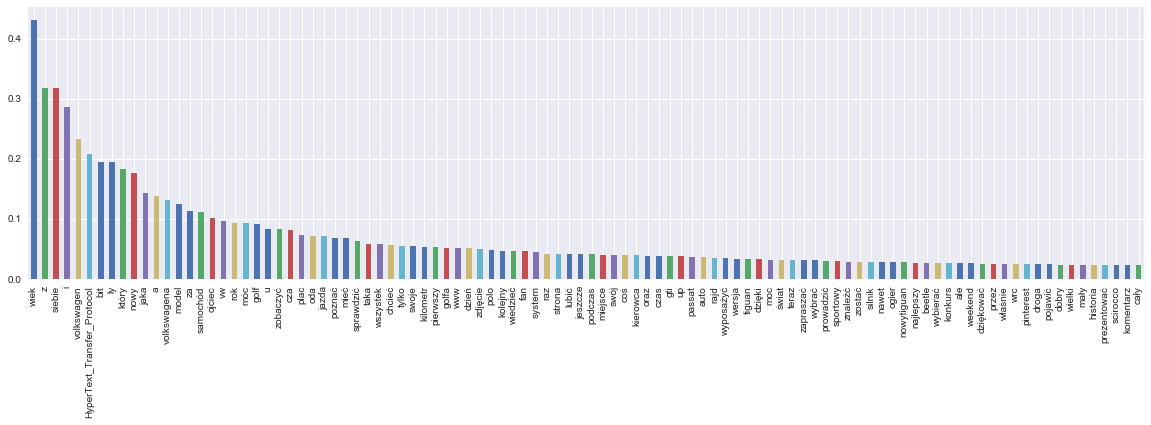

In [21]:
# plot word frequencies in descending order
plt.figure(figsize=(20,5))
(num_appearance/relevant.shape[0]).head(100).plot.bar();

wiek, z, sieble, i, volkswagen have highest frequencies in the FB posts.

In [22]:
relevant.head()

,HyperText_Transfer_Protocol,Post_text,Post_type,Post_utime,Shares_count,Total_comments,Total_likes,a,about,abs,...,żreć,żuczek,życie,życiowy,życzyć,żyto,żywioł,żywo,żywy,żółty
0,NaN,"[witać, wiek, rok, dzisiejszy, dzień, tylko, w...",photo,1325418888,0,2,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"[dakar, the, ultimate, rally, raca, oficjalnie...",video,1325505419,0,4,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"[up, deklasować, konkurencja, zajrzeć, najnows...",photo,1325610421,3,10,17,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"[mały, ale, z, charakter, jaka, uważać, dodawa...",photo,1325587400,1,9,11,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,"[taka, czas, wiek, rok, wiek, który, wyprzedaż...",photo,1325691193,4,10,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# calculate word metrics 
words = []
for word in relevant.columns:
    if (word in ['wv', 'bow', 'success', 'Post_text', 'Post_type', 'Post_utime', 'Shares_count', 'Total_comments', 'Total_likes']) or 'dim' in word:
        continue
    dat = relevant[~relevant[word].isnull()]
    metric = dat['success']
    word_dat = {
     'word': word,
     'count': metric[~metric.isnull().values].count(), # no. of posts the word appeared in
     'success_mean': metric[~metric.isnull().values].mean(), # mean success value when word appears in post
     'success_std': metric[~metric.isnull().values].std() # stdev of success value when word appears in post
    }
    words.append(word_dat)

In [24]:
word_summary = pd.DataFrame(words)[['word', 'count', 'success_mean', 'success_std']]

In [25]:
word_summary['word_rank'] = word_summary['word'].map(rank_dict)

In [26]:
# for significance, only analyze words that appeared in at least 50 posts
word_summary = word_summary[word_summary['count'] >= 50]

In [27]:
# we want "high-performing" words, so we retain onyl words that have success mean higher than the average over all words
word_summary = word_summary[(word_summary['success_mean'] >= word_summary['success_mean'].mean())].sort_values('success_mean', ascending=False)

In [28]:
word_summary.head()

,word,count,success_mean,success_std,word_rank
5184,zostać,58,97.844828,364.173621,0-25
2647,pierwszy,107,91.741822,274.336001,0-25
1122,gti,76,87.648026,73.194950,0-25
1059,golfa,104,84.612981,166.019674,NaN
3333,raz,85,83.473529,310.655304,0-25


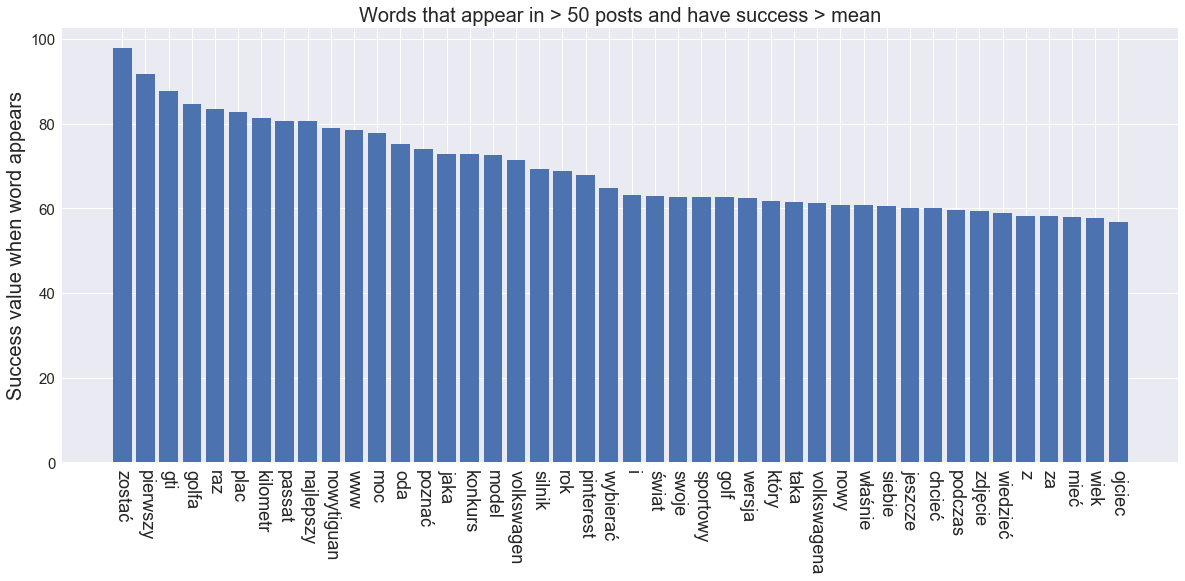

In [29]:
plt.figure(figsize=(20,8))
plt.bar(range(word_summary.shape[0]), word_summary['success_mean'])
plt.xticks(range(word_summary.shape[0]), word_summary['word'], rotation=270, size=18);
plt.yticks(size=15);
plt.ylabel('Success value when word appears', size=20)
plt.title('Words that appear in > 50 posts and have success > mean', size=20)

Success is high when zostac, pierwsky, gti, golfa, raz appear.

In [30]:
word_summary = word_summary.convert_objects(convert_numeric=True)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [31]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [32]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['dimension'].shape[0]):
        name = 'dim_' + str(k) + '_' + str(dimensions['en_label'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['dimension'].iloc[k])
    return row

In [33]:
def get_word_rank_count(row, rank_dict, rank_labels):
    """
        Get the frequency of the word rank deciles <10 to 90+
        row : row of movie dataframe
        rank_dict : dictionary from words to ranks
        rank_labels : labels for the word rank deciles
    """
    word_count = len(row['Post_text'])
    running = 0
    for k in range(4):
        # count the number of words belonging to quartile k
        total = np.sum([1 for y in [rank_dict[x] for x in row['Post_text'] if x in rank_dict.keys()] if y == rank_labels[k]]) 
        # divide by the total number of words to get frequency
        freq = total / word_count
        row['freq_' + rank_labels[k]] = freq
        running += freq
    row['freq_notinemb'] = 1 - running
    return row


In [34]:
# get average word vector of text in each post
relevant['wv'] = relevant['Post_text'].map(lambda x: get_average_vector(x, emb))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [35]:
# add a column for similarity with every dimension
relevant = relevant.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [36]:
post_dims = relevant[[x for x in relevant.columns if 'dim' in x] + ['success']]

In [37]:
# save dimension data
post_dims.to_csv('./data/post_dims.csv', index=False)

# Correlations with Dimensions
Here we look at correlations of dimensions and success.

In [38]:
post_dims = post_dims.convert_objects(convert_numeric=True)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [39]:
# divide percentiles of success in steps of 5
post_dims['percentile'] = pd.qcut(post_dims['success'], 20, range(20))

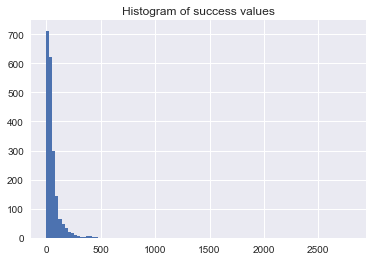

In [40]:
post_dims['success'].hist(bins=100);
plt.title('Histogram of success values');

We see here a very skewed distribution for the success metric. Let us remove the top 5%.

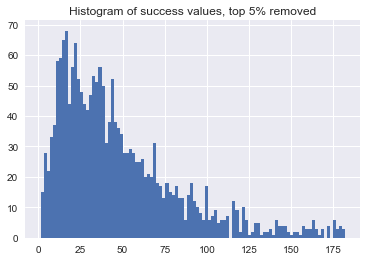

In [41]:
post_dims[post_dims['percentile'] != 19]['success'].hist(bins=100);
plt.title('Histogram of success values, top 5% removed');

In [42]:
sorted_dims = post_dims[post_dims['percentile'] != 19].corr()['success'].sort_values(ascending=False)
sorted_dims = sorted_dims[~pd.isnull(sorted_dims)]
sorted_dims = sorted_dims.loc[[x for x in sorted_dims.index if 'dim' in x]]
# retain top 10 dimensions with most pos and most neg correlations
retain_dims = list(sorted_dims.head(10).index) + list(sorted_dims.tail(10).index)

In [43]:
sorted_dims[~pd.isnull(sorted_dims)].loc[[x for x in sorted_dims.index if 'dim' in x]]

dim_5_altmodisch             0.092436
dim_1_african_names          0.089524
dim_104_trust                0.072761
dim_125_volkswagen           0.071066
dim_102_nan                  0.036175
dim_2_african_names_2004     0.028317
dim_25_design                0.015636
dim_34_european_names        0.015554
dim_13_blue_collar           0.011963
dim_111_nan                  0.010872
dim_65_musical_instrument    0.002111
dim_98_traditional           0.001977
dim_52_innovative_rachel     0.000464
dim_27_innovative            0.000464
dim_107_nan                 -0.002377
dim_23_dead                 -0.002667
dim_24_descriptive          -0.004455
dim_106_ugly                -0.006077
dim_31_electric             -0.008507
dim_76_power                -0.008619
dim_18_closed               -0.010118
dim_9_basic                 -0.013584
dim_123_white_names_1998    -0.015359
dim_116_untrustworthy       -0.015468
dim_89_technical            -0.015523
dim_112_unpleasant          -0.015838
dim_8_bad   

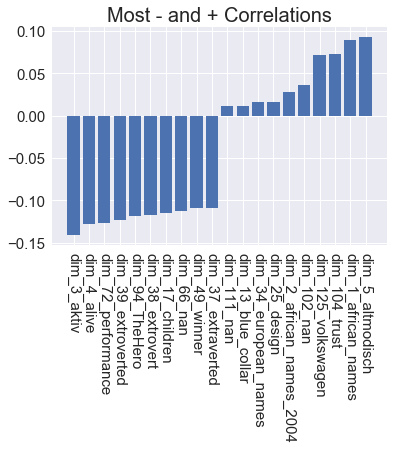

In [44]:
to_plot = sorted_dims[retain_dims].sort_values(ascending=True)
plt.bar(range(len(to_plot.index)), to_plot.values)
plt.xticks(range(len(to_plot.index)), to_plot.index, rotation=270, size=15);
plt.yticks(size=15)
plt.title('Most - and + Correlations', size=20)
plt.savefig('./fig/bottom_top_dims.png', bbox_inches='tight')

**Negative**: aktiv, alive, performance, extroverted, children (These seem counterintuitive)

**Positive**: altmodisch, african names, trust, volkswagen, blue collar

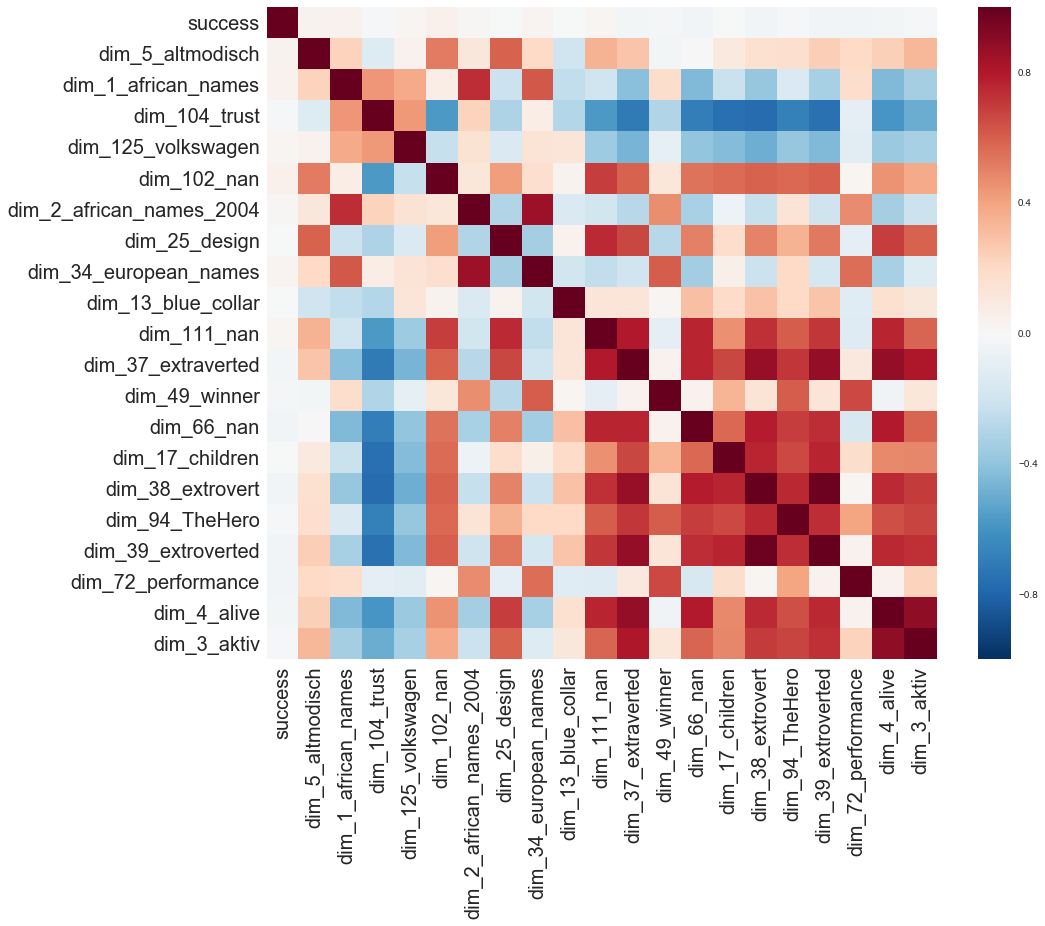

In [45]:
plt.figure(figsize=(15,12))
sns.heatmap(post_dims[['success'] + retain_dims].corr())
plt.xticks(size=20);
plt.yticks(size=20);
plt.savefig('./fig/corre_average.png', bbox_inches='tight')

# Conclusion
In this notebook, we looked at correlations of dimension similarities with success in the case when posts are represented by the average of the word vectors of the constituent words.

We saw that aktiv, alive, performance, extroverted, children were inversely correlated with success, and altmodisch, african names, trust, volkswagen, blue collar were correlated with success, which are very counterintuitive correlations (considering in the VW presentation we saw that innovative is correlated with success). It is possible that these correlations are not significant.

I don't think that averaging words to get sentence vectors is such a good idea. In the next notebook, we look at an alternative representation.